# Topic Modeling using LDA

Originally, I was introduced to __Latent Dirichlet Distribution__ for topic modelling in **CS447 Natural Language Processing** course. I am taking the course as part of the **Master's of Data Science** program at the **University of Rochester**. Topic modeling useing LDA was the first assignment of the course. This is an extension of that assignment where I go deeper into experimenting with the gensim LDA model. I also dive into evaluation metrics like **perplexity** and **coherence score** to evaluate the LDA model.

This project is also my introduction to using **BlueHive**, the amazing cloud computing resource, provided by **CIRC** at the UoR. The project wouldn't have been possible without it.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Typing
from typing import List

## CIRC Initialization

This project was done on the University of Rochester's cloud computing services provided by CIRC. Somethings need to be setup for it specifically.

In [2]:
# Required for CIRC.jupyter
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

## 1. Importing Dataset

I'll be using the **News Group** dataset to perform topic modeling.

In [3]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


There are 20 topics in the dataset and the dataset already labels each of the topics.

In [4]:
df.target_names.unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'],
      dtype=object)

## 2. Dataset Preprocessing

Before feeding the data into an LDA model, the text needs to be processed for better accuracy. In particular, I'll be first cleaning the text by removing artifacts and then perform word tokenization and lemmatization.

### 2.1. Data Cleaning

#### 2.1.1. Removing Email Addresses

In [5]:
def remove_email_addresses(text: str) -> str:
    return re.sub(r"\S*@\S*\s?", "", text)

#### 2.1.2. Substitute Multiple Spaces with a Single Space

In [6]:
def remove_multiple_space_chars(text: str) -> str:
    return re.sub(r"\s+", " ", text)

#### 2.1.3. Removing Punctuations

In [7]:
def remove_punctuations(text: str) -> str:
    return re.sub(r"[^0-9a-zA-Z\s]", "", text)

#### 2.1.4. Removing Stopwords

In [8]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sishfar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
stop_word_pattern = r'\b' + r'\b|\b'.join(stop_words) + '\b'

def remove_stop_words(text: str) -> str:
    return re.sub(stop_word_pattern, '', text)

#### 2.1.5. Chaining Functions

In [10]:
def clean_text(text: str) -> str:
    clean_funcs = [remove_email_addresses,
                  remove_punctuations,
                  remove_stop_words,
                  remove_multiple_space_chars]
    
    for func in clean_funcs:
        text = func(text)
        
    return text

In [11]:
clean_text("This is$ #a 'test'")

'This test'

The `clean_text` function can be called with pandas `apply` method to clean the entire **content** column.

In [12]:
print(f"Before cleaning\n{df.content.iloc[0]}")

Before cleaning
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [13]:
df.content = df.content.apply(lambda x: clean_text(x))

In [14]:
print(f"After cleaning\n{df.content.iloc[0]}")

After cleaning
From wheres thing Subject WHAT car NntpPostingHost rac3wamumdedu Organization University Maryland College Park Lines 15 I wondering anyone could enlighten car I saw day It 2door sports car looked late 60s early 70s It called Bricklin The doors really small In addition front bumper separate rest body This I know If anyone tellme model name engine specs years production car made history whatever info funky looking car please email Thanks IL brought neighborhood Lerxst 


### 2.2. Token Processing

#### 2.2.1. Tokenization

Breaking a sentence into list of words it is composed of. I'll also convert the sentence to only have lower case characters.

In [15]:
def tokenize(texts_in: List[str]) -> List[List[str]]:
    return [word_tokenize(text.lower())
           for text in texts_in]


tokenize(["This is a simple test", "This is a 2nd test"])

[['this', 'is', 'a', 'simple', 'test'], ['this', 'is', 'a', '2nd', 'test']]

In [16]:
data = df.content.values.tolist()
data_tokens = tokenize(data)

In [17]:
print(data_tokens[0])

['from', 'wheres', 'thing', 'subject', 'what', 'car', 'nntppostinghost', 'rac3wamumdedu', 'organization', 'university', 'maryland', 'college', 'park', 'lines', '15', 'i', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'i', 'saw', 'day', 'it', '2door', 'sports', 'car', 'looked', 'late', '60s', 'early', '70s', 'it', 'called', 'bricklin', 'the', 'doors', 'really', 'small', 'in', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'this', 'i', 'know', 'if', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'email', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


#### 2.2.2. Creating n-grams

An n-gram is a sequence of n-words that are commonly occuring. I'm mostly interested in bigrams and trigrams.

##### Creating n-gram models

In [18]:
bigram = gensim.models.Phrases(data_tokens, 
                               min_count=5, 
                               threshold=100)
trigram = gensim.models.Phrases(bigram[data_tokens], 
                                threshold=100)

##### Creating Phraser

Faster way to get a sentence clubbed as a trigram/bigram

In [19]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
print(trigram_mod[bigram_mod[data_tokens[0]]])

['from', 'wheres', 'thing', 'subject', 'what', 'car', 'nntppostinghost_rac3wamumdedu', 'organization', 'university_maryland_college', 'park', 'lines', '15', 'i', 'wondering_anyone', 'could', 'enlighten', 'car', 'i', 'saw', 'day', 'it', '2door', 'sports', 'car', 'looked', 'late_60s', 'early_70s', 'it', 'called', 'bricklin', 'the', 'doors', 'really', 'small', 'in_addition', 'front_bumper', 'separate', 'rest', 'body', 'this', 'i', 'know', 'if', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'email', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


##### Convertion Functions

In [21]:
def make_bigrams(texts: List[List[str]]) -> List[List[str]]:
    return [bigram_mod[text] for text in texts]

In [22]:
def make_trigrams(texts: List[List[str]]) -> List[List[str]]:
    return [trigram_mod[bigram_mod[text]]
           for text in texts]

#### 2.2.3. Lemmatization

Breaking words into their dictionary forms or lemmas.

In [23]:
def lemmatization(texts_in: List[List[str]], 
                  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
                 ) -> List[List[str]]:
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    return [[token.lemma_ 
             for token in nlp(" ".join(text)) 
             if token.pos_ in allowed_postags]
            for text in texts_in]

In [24]:
print(lemmatization([data_tokens[0]]))

[['s', 'thing', 'subject', 'car', 'nntppostinghost', 'organization', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'sport', 'car', 'look', 'late', '60', 'early', '70', 'call', 'door', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'email', 'thank', 'bring', 'neighborhood', 'lerxst']]


#### 2.2.4. Combining Token Processing

In this step, I'll combine the previous making n-grams and lemmatization steps together.

In [25]:
def process_tokens(texts_in: List[List[str]]) -> List[List[str]]:
    word_trigrams = make_trigrams(texts_in)
    return lemmatization(word_trigrams)

print(process_tokens([data_tokens[0]]))

[['s', 'thing', 'subject', 'car', 'organization', 'university_maryland_college', 'park', 'line', 'enlighten', 'car', 'see', 'day', 'sport', 'car', 'look', 'late_60s', 'call', 'door', 'really', 'small', 'in_addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'email', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [26]:
data_tokens = process_tokens(data_tokens)

In [27]:
print(data_tokens[0])

['s', 'thing', 'subject', 'car', 'organization', 'university_maryland_college', 'park', 'line', 'enlighten', 'car', 'see', 'day', 'sport', 'car', 'look', 'late_60s', 'call', 'door', 'really', 'small', 'in_addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'email', 'thank', 'bring', 'neighborhood', 'lerxst']


## 3. Topic Modeling

### 3.1. Preparing LDA Arguments

LDA needs two arguments 

1. A dictionary mapping integers to word tokens.
2. A term frequency document matching token id to frequency.

#### 3.1.1. Dictionary

This is a simple mapping of an integer to a token.

In [28]:
id2word = corpora.Dictionary(data_tokens)

In [29]:
print(id2word.doc2bow(data_tokens[0]))

[(0, 1), (1, 1), (2, 1), (3, 5), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]


#### 3.1.2. Term Document Frequency

A list of token ids and their frequency in the dataset.

In [30]:
corpus = [id2word.doc2bow(tokens)
         for tokens in data_tokens]

In [31]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 5), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]


This is hard to parse. Let's replace the token id with the actual word.

In [32]:
print([[(id2word[id], freq) 
        for id, freq in cp] 
       for cp in corpus[:1]])

[[('body', 1), ('bring', 1), ('call', 1), ('car', 5), ('day', 1), ('door', 1), ('email', 1), ('engine', 1), ('enlighten', 1), ('funky', 1), ('history', 1), ('in_addition', 1), ('info', 1), ('know', 1), ('late_60s', 1), ('lerxst', 1), ('line', 1), ('look', 2), ('make', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('organization', 1), ('park', 1), ('production', 1), ('really', 1), ('rest', 1), ('s', 1), ('see', 1), ('separate', 1), ('small', 1), ('spec', 1), ('sport', 1), ('subject', 1), ('tellme', 1), ('thank', 1), ('thing', 1), ('university_maryland_college', 1), ('year', 1)]]


### 3.2. Creating LDA Model

#### 3.2.1. Training

In [33]:
warnings.filterwarnings("ignore")
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### 3.2.2. Understanding the Topics

In [34]:
pprint(lda_model.print_topics())

[(0,
  '0.030*"file" + 0.030*"program" + 0.027*"use" + 0.025*"window" + 0.017*"run" '
  '+ 0.015*"set" + 0.014*"entry" + 0.012*"application" + 0.011*"disk" + '
  '0.010*"problem"'),
 (1,
  '0.039*"drive" + 0.020*"use" + 0.016*"chip" + 0.015*"cpu" + 0.014*"pin" + '
  '0.011*"work" + 0.011*"connect" + 0.011*"slave" + 0.010*"board" + '
  '0.010*"sin"'),
 (2,
  '0.043*"line" + 0.025*"subject" + 0.023*"thank" + 0.022*"organization" + '
  '0.018*"email" + 0.017*"card" + 0.015*"computer" + 0.014*"use" + '
  '0.014*"nntppostinghost" + 0.013*"need"'),
 (3,
  '0.019*"car" + 0.013*"buy" + 0.012*"price" + 0.011*"new" + 0.011*"sell" + '
  '0.010*"player" + 0.009*"lose" + 0.009*"drive" + 0.009*"home" + '
  '0.009*"sale"'),
 (4,
  '0.021*"m" + 0.021*"drug" + 0.016*"t" + 0.011*"g" + 0.009*"battery" + '
  '0.009*"hook" + 0.007*"probe" + 0.006*"annual" + 0.005*"up" + '
  '0.005*"re_ide_vs"'),
 (5,
  '0.024*"hockey" + 0.017*"fan" + 0.009*"helmet" + 0.008*"1st" + '
  '0.008*"period" + 0.007*"series" + 0.0

#### 3.2.3. Visualizing

In [35]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.326340 -0.037930       1        1  24.395739
6     -0.281812 -0.165426       2        1  12.241646
15    -0.234290  0.024454       3        1  11.142782
3     -0.076410  0.046396       4        1   6.558812
2     -0.154982  0.213429       5        1   5.729196
0     -0.101846  0.197650       6        1   5.253041
17    -0.053743 -0.224539       7        1   5.044866
13     0.023646 -0.204783       8        1   3.098838
1      0.015261  0.177077       9        1   2.854626
19     0.117985  0.007106      10        1   2.800442
14     0.056543  0.074554      11        1   2.675722
18     0.099644 -0.051174      12        1   2.641653
16     0.098550  0.021873      13        1   2.554459
12     0.093919  0.023770      14        1   2.157701
7      0.074200 -0.028985      15        1   2.156958
9      0.114051 -0.046405      16        1   2.097403
11     0.122609 -0.014611      17        1   2.090358
8      0.130658 -0.023716      18        1   1.725716
5      0.143092 -0.005317      19        1   1.528761
4      0.139264  0.016577      20        1   1.251281, topic_info=              Term          Freq         Total Category  logprob  loglift
16            line  12822.000000  12822.000000  Default  30.0000  30.0000
33         subject   9477.000000   9477.000000  Default  29.0000  29.0000
202          write   9979.000000   9979.000000  Default  28.0000  28.0000
22    organization   8361.000000   8361.000000  Default  27.0000  27.0000
169            use   8590.000000   8590.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
3319       sustain     39.593520     40.537603  Topic20  -5.9531   4.3574
5646          junk     38.752142     39.696225  Topic20  -5.9746   4.3569
6486      memorial     36.107731     37.051814  Topic20  -6.0453   4.3552
3316    peripheral     35.070798     36.014881  Topic20  -6.0744   4.3544
126              m    324.603491   4308.906709  Topic20  -3.8492   1.7952

[969 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2276     19  0.992334   1st
652       4  0.048354   2nd
652       6  0.103616   2nd
652      17  0.013815   2nd
652      19  0.822017   2nd
...     ...       ...   ...
38        7  0.052417  year
38        8  0.013449  year
38       14  0.031381  year
38       15  0.181390  year
38       16  0.004483  year

[1451 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 16, 4, 3, 1, 18, 14, 2, 20, 15, 19, 17, 13, 8, 10, 12, 9, 6, 5])

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

### 3.3. Evaluating LDA Model

We can mathematically express the performance of the model using **perplexity** and **coherence score**.

#### 3.3.1. Perplexity

A measure of how good the model is. lower the better.

In [36]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 


Perplexity:  -9.113644761131619


#### 3.3.2. Coherence Score

The higher the better

In [37]:
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_tokens, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.46734341235307786


### 3.4. Tuning Hyperparameters

There are many hyperparameters in LDA. But I'll be focusing on finding the optimal **number of topics**.

#### 3.4.1. Varying Number of Topics

To find it's optimal value we'll need to try out different values and see what evaluation measurement we get. I attempt to find the optimal number using the training dataset. Ideally, it should be done using a separate validation dataset.

In [38]:
def compute_coherence_values(start: int, end: int, step: int):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, end, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=data_tokens, 
                                        dictionary=id2word, 
                                        coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        
        print(f"Topic = {num_topics} \t\t Coherence Score = {coherence_score}")

    return model_list, coherence_values

In [39]:
start, end, step = 5, 30, 5

warnings.filterwarnings("ignore")
model_list, coherence_values = compute_coherence_values(start, end, step)

Topic = 5 		 Coherence Score = 0.4307697121692201
Topic = 10 		 Coherence Score = 0.4625249982026854
Topic = 15 		 Coherence Score = 0.4783734442683365
Topic = 20 		 Coherence Score = 0.46734341235307786
Topic = 25 		 Coherence Score = 0.46416950570519455


#### 3.4.2. Visualizing Varying no of Topics

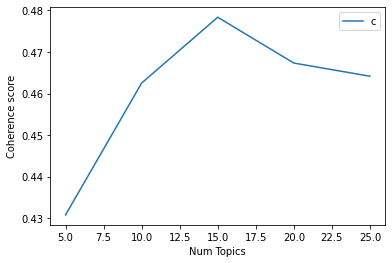

In [41]:
x = range(start, end, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

It looks like the curve flattens out just after 20 topics. So the optimal value for the number of topics is 20.